In [1]:
import ee
from datetime import datetime, timedelta
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
datelist = pd.date_range(datetime.today(), periods=100).tolist()
from time import sleep
import dask.dataframe as dd
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import os
import glob
from datetime import date

from uuid import uuid4


from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection
import plotly
import plotly.express as px
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import geopandas as gpd
import seaborn as sns

import dask.dataframe as dd
import geopandas as gpd
from heatwave_1 import detect
from datetime import timedelta
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

In [2]:
monthly = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps/monthly.csv')
bc_daily = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps/max_daily.csv')
weekly = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps/05_weekly_v2.csv')

weekly_v2 = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps/05_weekly_v2_2022.csv')

weekly_v3 = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps/05_weekly_v3_2022.csv')


okanagan = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps/okanagan.csv')




full_df = pd.concat([monthly, weekly, bc_daily, weekly_v2, weekly_v3, okanagan])


full_df['datetime'] = pd.to_datetime(full_df[['day', 'month', 'year']])


full_df['location'] = full_df['county'] + ', ' + full_df['state']
full_df.drop_duplicates(['location', 'datetime'], inplace=True)



In [102]:


full_df = full_df[(full_df['month'] != 10)]
full_df = full_df[(full_df['month'] != 4)]








full_df = full_df[(full_df['month'] != 10)]
full_df = full_df[(full_df['month'] != 4)]

full_df['pct'] = full_df.groupby('location')['temperature_2m'].transform(lambda x: x.rank(pct=True))


In [103]:
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]



In [105]:
full_df.to_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps/max_temps.csv')

In [3]:
full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps/max_temps.csv')
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['temp_pct'] = full_df.groupby('location')['temperature_2m'].transform(lambda x: x.rank(pct=True))

## Find heat waves, heat wave lengths and assign unique heatwave IDs

In [4]:
full_df.groupby('state')['temperature_2m'].describe()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
British Columbia,31059.0,17.206868,5.838628,-3.833495,13.039307,16.878905,21.182734,40.556122
California,62118.0,28.761845,6.540408,-1.761651,24.418456,29.205988,33.374152,48.168298
Oregon,38556.0,23.901303,6.378744,3.300500,19.300490,24.052061,28.771165,44.426642
Washington,41769.0,23.126239,6.758373,1.808146,18.046032,22.758421,27.948832,46.928690


In [5]:
#create dictionary containing each county's heatwave periods
heatwave_dic = {}
for county in full_df['location'].unique():
    county_df = full_df[(full_df['location'] == county)]
    county_df.reset_index(inplace=True)
    county_df.sort_values(by='datetime', inplace=True)
    county_df.drop_duplicates(['county', 'datetime'], inplace=True)
    heatwave_dic[county] = detect(county_df['datetime_ord'].values, county_df['temperature_2m'].values, pctile=90, climatologyPeriod = [None, None], minDuration=2)

    
heatwave_dates = {}
consec_dates = {}
heatwave_IDs = {}
for county in heatwave_dic.keys(): 
    consec_dates[county] = {}
    heatwave_dates[county] = []
    heatwave_IDs[county] = {}


    heatwave_starts = heatwave_dic[county][0]['date_start']
    heatwave_ends = heatwave_dic[county][0]['date_end']
    for i in range(len(heatwave_starts)):
        heatwave_code = str(uuid4())
        heatwave_days = pd.date_range(heatwave_starts[i],heatwave_ends[i],freq='d')
        length_heatwaves = len(heatwave_days)
        consec_dates[county][heatwave_days[0]] = length_heatwaves
        for item in heatwave_days:
            heatwave_dates[county].append(item)
            heatwave_IDs[county][item] = heatwave_code
            
            
heat_df = pd.DataFrame.from_dict(heatwave_dates, orient='index').unstack().reset_index()
heat_df.rename(columns={'level_1':'location', 0:'datetime'}, inplace=True)


heat_df.dropna(inplace=True)
heat_df['heatwave']=1

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_96978/674917538.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df.sort_values(by='datetime', inplace=True)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_96978/674917538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df.drop_duplicates(['county', 'datetime'], inplace=True)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_96978/674917538.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [6]:
full_df = full_df.merge(heat_df, on=['location', 'datetime'], how='left')

full_df['heatwave'] = full_df['heatwave'].replace(np.nan, 0)

In [7]:
full_df['pct'] = full_df.groupby('location')['temperature_2m'].transform(lambda x: x.rank(pct=True))

In [8]:
full_df

,Unnamed: 0.1,Unnamed: 0,county,day,month,year,temperature_2m,state,datetime,location,pct,datetime_ord,temp_pct,level_0,heatwave
0,0,0,Alameda,1,5,2016,25.669851,California,2016-05-01,"Alameda, California",0.281046,736085,0.281046,NaN,0.0
1,1,1,Alameda,2,5,2016,23.854361,California,2016-05-02,"Alameda, California",0.184874,736086,0.184874,NaN,0.0
2,2,2,Alameda,3,5,2016,22.226776,California,2016-05-03,"Alameda, California",0.121382,736087,0.121382,NaN,0.0
3,3,3,Alameda,4,5,2016,21.888104,California,2016-05-04,"Alameda, California",0.102708,736088,0.102708,NaN,0.0
4,4,4,Alameda,5,5,2016,19.126340,California,2016-05-05,"Alameda, California",0.041083,736089,0.041083,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173497,3145,170,Thompson-Nicola,26,6,2022,22.764207,British Columbia,2022-06-26,"Thompson-Nicola, British Columbia",0.748833,738332,0.748833,NaN,0.0
173498,3146,171,Thompson-Nicola,27,6,2022,25.425505,British Columbia,2022-06-27,"Thompson-Nicola, British Columbia",0.878618,738333,0.878618,NaN,0.0
173499,3147,172,Thompson-Nicola,28,6,2022,25.263285,British Columbia,2022-06-28,"Thompson-Nicola, British Columbia",0.870215,738334,0.870215,NaN,0.0
173500,3148,173,Thompson-Nicola,29,6,2022,16.018949,British Columbia,2022-06-29,"Thompson-Nicola, British Columbia",0.368814,738335,0.368814,NaN,0.0


In [9]:
full_df[full_df['heatwave'] == 1].groupby('state')['temperature_2m'].describe()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
British Columbia,2994.0,26.823536,3.372774,17.726235,24.812239,26.934887,28.894093,40.556122
California,5671.0,36.132868,4.298267,24.768563,33.492891,35.891154,39.268191,48.168298
Oregon,3608.0,33.672870,2.841513,23.772982,32.317623,33.780383,35.370447,44.426642
Washington,4046.0,32.858483,4.403586,20.540545,29.814970,33.120834,35.761427,46.928690


In [10]:
codes = pd.DataFrame.from_dict(heatwave_IDs, orient='index').unstack().reset_index()

In [11]:
codes.columns=['datetime', 'location', 'heat_ID']

In [12]:
codes.dropna(inplace=True)

In [13]:
consec = pd.DataFrame.from_dict(consec_dates, orient='index').unstack().reset_index()

In [14]:
consec.columns= ['datetime', 'location', 'Heat Wave Duration']

In [15]:
consec['Heat Wave Duration'].max()

13.0

In [16]:
consec.dropna(inplace=True)

In [17]:
consec

,datetime,location,Heat Wave Duration
0,2016-07-26,"Alameda, California",3.0
1,2016-07-26,"Amador, California",5.0
2,2016-07-26,"Butte, California",5.0
3,2016-07-26,"Colusa, California",5.0
4,2016-07-26,"Contra Costa, California",2.0
...,...,...,...
59092,2017-06-08,"Stikine, British Columbia",2.0
59254,2018-07-21,"Stikine, British Columbia",13.0
59416,2019-06-28,"Stikine, British Columbia",5.0
59578,2019-08-03,"Stikine, British Columbia",5.0


In [18]:
full_df = full_df.merge(codes, on=['datetime', 'location'])

In [19]:
full_df = full_df[full_df['year'] >= 2020]



In [20]:
full_df = full_df.merge(consec, on=['datetime', 'location'], how='left')

In [21]:
full_df['heat_ID'].value_counts()

d2676138-0e44-4e3b-a520-d57535b348fa    12
78134db6-a5b9-4fb3-9edb-1935981c3e35    11
723b5750-1de5-4eed-8713-a03ca2a62bab    11
586e723f-ba69-4722-906b-68aced80ad67    11
23eb79b8-ebd4-4d95-86bb-3e748832b960    11
                                        ..
df5cc629-ad53-432f-9449-0167181c89d7     2
f81d520d-d472-4a7d-a32e-0d6e97891f03     2
b192bbff-bf4b-4857-833c-c2093dae9bee     2
cbdee361-246b-4324-9617-87ccbccdbf68     2
01f6b22d-6c6c-4ecc-8343-db7351a51435     2
Name: heat_ID, Length: 2280, dtype: int64

In [22]:
heatwaves = full_df.copy()

In [23]:
heatwaves['location'] = heatwaves['county'] + ', ' + heatwaves['state']

In [24]:
heatwaves['datetime'] = pd.to_datetime(heatwaves['datetime'])

In [25]:
heatwaves = heatwaves.merge(consec, on=['datetime', 'location'], how='left')

In [26]:
heatwaves = heatwaves[heatwaves['year'] >= 2019]
#heatwaves = heatwaves[heatwaves['month'] != 5]
heatwaves = heatwaves[heatwaves['month'] != 10]

In [27]:
heatwaves.sort_values('datetime', inplace=True)

In [28]:
heatwaves.sort_values(by='datetime', inplace=True)

In [29]:
#heatwaves = heatwaves[heatwaves['month'] != 5]
heatwaves = heatwaves[heatwaves['month'] != 10]

In [30]:
heatwaves.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/heatwave_clean_90.csv')

### Read heat wave file and begin analysis

In [ ]:
heatwaves = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/heatwave_full_95.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/heatwave_full_95.csv'

## Describing Heatwaves

In [2]:
sns.set_style('darkgrid')

In [3]:
heatwaves = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/heatwave_full.csv')

In [57]:
means = heatwaves.groupby('state')['Heat Wave Duration'].mean().reset_index()

In [58]:
maxes = heatwaves.groupby('state')['Heat Wave Duration'].max().reset_index()

In [59]:
mins = heatwaves.groupby('state')['Heat Wave Duration'].min().reset_index()

Text(0.5, 1.0, 'Mean Heat Wave Durations by State')

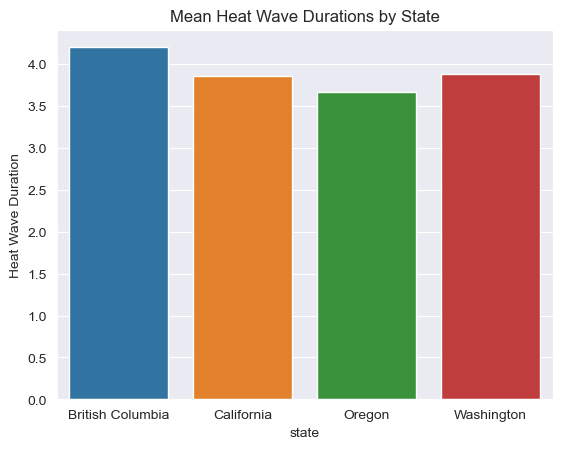

In [60]:
sns.barplot(means, x='state', y='Heat Wave Duration')
plt.title('Mean Heat Wave Durations by State')

Text(0.5, 1.0, 'Max Heat Wave Durations by State')

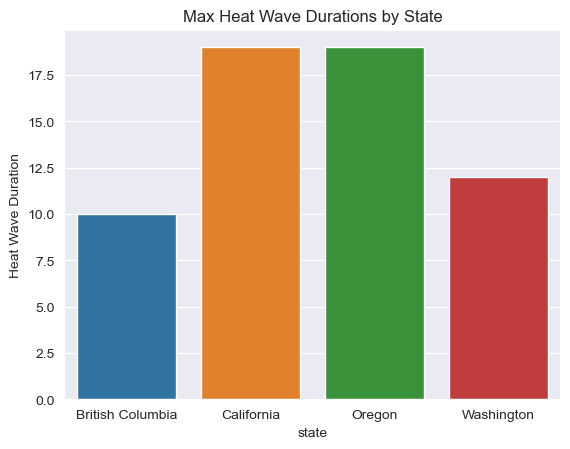

In [61]:
sns.barplot(maxes, x='state', y='Heat Wave Duration')
plt.title('Max Heat Wave Durations by State')

## Create Scatterplot of each heat wave's average temperature and duration

#### 1. Get heat wave average temp

In [56]:
mean_heatwave_temps = heatwaves.groupby('heat_ID')['temperature_2m'].mean().reset_index().sort_values(by='temperature_2m', ascending=False)

#### 2. Get heat wave average duration

In [57]:
ID_durations = heatwaves.groupby('heat_ID')['Heat Wave Duration'].mean().reset_index()

#### 3. Merge

In [58]:
heatwave_info = mean_heatwave_temps.merge(ID_durations, on='heat_ID')

In [59]:
heatwave_info = heatwave_info.merge(heatwaves[['heat_ID', 'state']].drop_duplicates())

In [60]:
heatwave_info['temp_percentile'] = heatwave_info['temperature_2m'].rank(pct=True)

In [61]:
heatwave_info['duration_percentile'] = heatwave_info['Heat Wave Duration'].rank(pct=True)

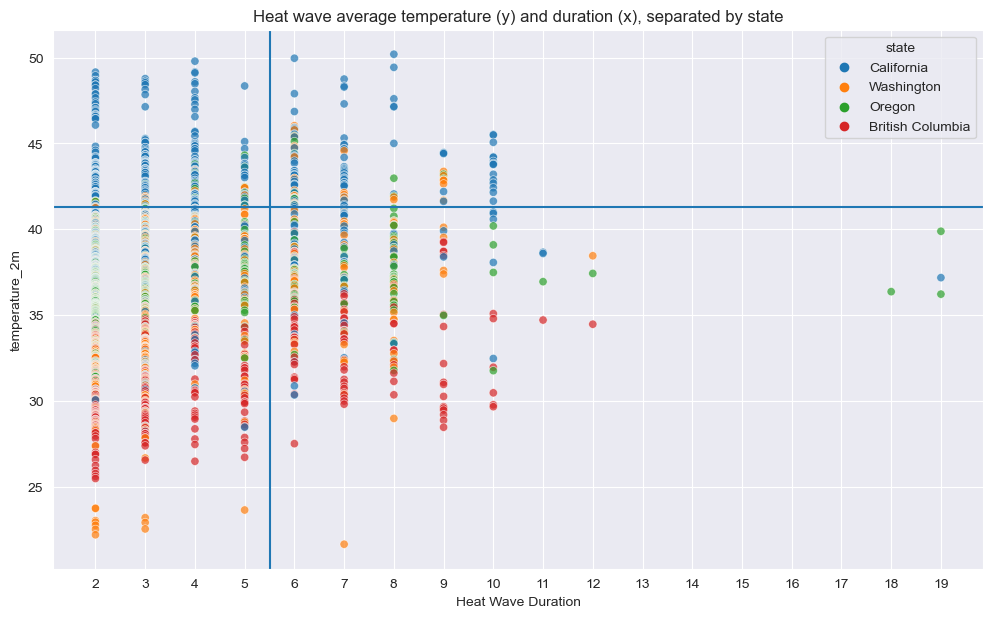

In [63]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(heatwave_info, x='Heat Wave Duration', y='temperature_2m', hue='state',  ax=ax, alpha=0.7)
ax.axhline(np.percentile(heatwave_info['temperature_2m'], q=80))
ax.axvline(np.percentile(heatwave_info['Heat Wave Duration'], q=80) - 0.5)
ax.set_xticks(range(int(min(heatwave_info['Heat Wave Duration'])), int(max(heatwave_info['Heat Wave Duration']+1))))
plt.title("Heat wave average temperature (y) and duration (x), separated by state")
plt.show()

## How to Characterize Heat Wave/Location Severity?

1. Temperature (absolute temp and relative change from county mean)
2. Frequency
3. Duration


In [532]:
sns.set_style('darkgrid')
sns.set_palette('tab10')

In [533]:
heatwaves = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/complete_heatwaves/heatwaves.csv')

In [534]:
is_heatwave = heatwaves[heatwaves['heatwave'] == 1]
is_heatwave.sort_values(by='state', inplace=True, ascending=True)

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_64061/1973070486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_heatwave.sort_values(by='state', inplace=True, ascending=True)


### Exploratory Plot: Duration and temperature of heat waves, Coloured by State

Thoughts
* California has the most heat waves above the 80th percentile of temperature and duration
* British Columbia's heat waves occupy lower end of temperature spectrum, but Washington state has the lowest temperature heat waves



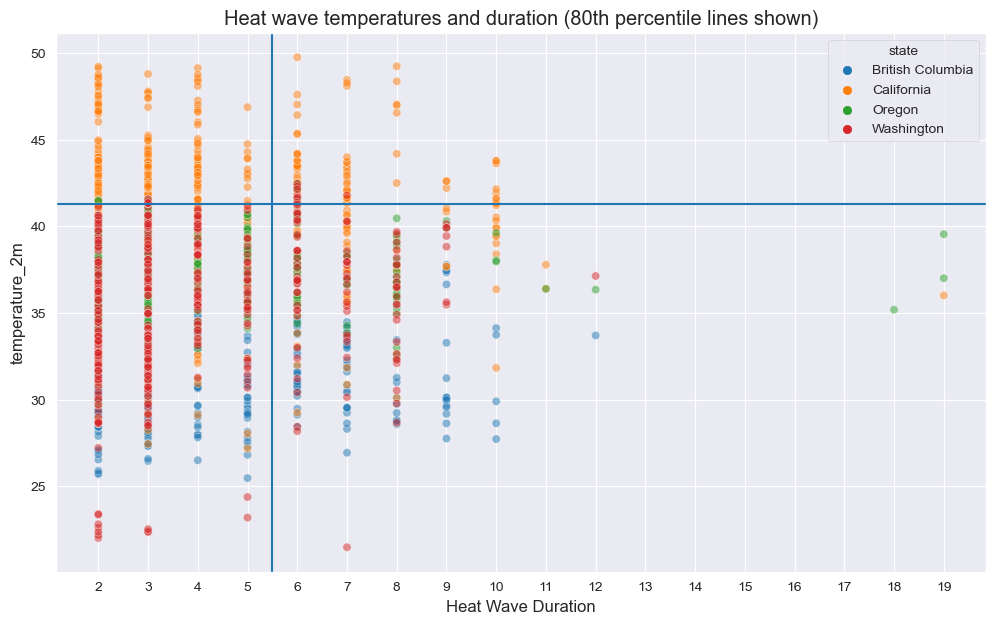

In [535]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(is_heatwave, x='Heat Wave Duration', y='temperature_2m', hue='state',  ax=ax, alpha=0.5)
ax.axhline(np.percentile(heatwave_info['temperature_2m'], q=80))
ax.axvline(np.percentile(heatwave_info['Heat Wave Duration'], q=80) - 0.5)
ax.set_xticks(range(int(min(heatwave_info['Heat Wave Duration'])), int(max(heatwave_info['Heat Wave Duration']+1))))
plt.title("Heat wave temperatures and duration (80th percentile lines shown)")
plt.show()

### Explore heat wave temperature summary statistics 
Thoughts
* California has the highest average heat wave temperatures (40.9), followed by Oregon (37.0), Washington (36.6), and British Columbia (32.46)
* Standard deviation has the same order as above

In [536]:
is_heatwave.groupby('state')['temperature_2m'].describe()[['mean', 'std', 'min', 'max']].style.background_gradient(cmap='Reds')

,mean,std,min,max
state,,,,
British Columbia,32.460041,3.388922,24.849542,44.067896
California,40.960580,4.088738,27.185403,51.490472
Oregon,37.040712,3.513097,21.910425,48.115305
Washington,36.636541,4.590518,21.027460,48.115305


In [537]:
temp_means = heatwaves.groupby('state')['temperature_2m'].mean().reset_index()
temp_means.sort_values(by='state', inplace=True, ascending=True)

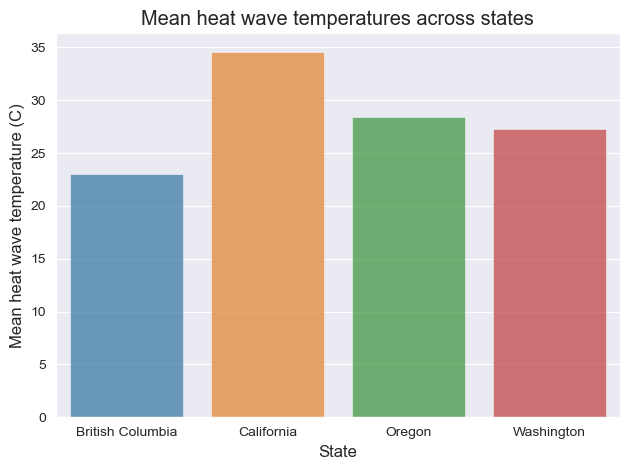

In [538]:
sns.barplot(temp_means, x='state', y='temperature_2m',alpha=0.7)
plt.title("Mean heat wave temperatures across states")
plt.ylabel('Mean heat wave temperature (C)')
plt.xlabel('State')
plt.tight_layout()
plt.savefig(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/eadi_img/mean_temps.png', dpi=500)
plt.show()


In [539]:
is_heatwave.sort_values(by='state', inplace=True, ascending=True)

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_64061/1930033767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_heatwave.sort_values(by='state', inplace=True, ascending=True)


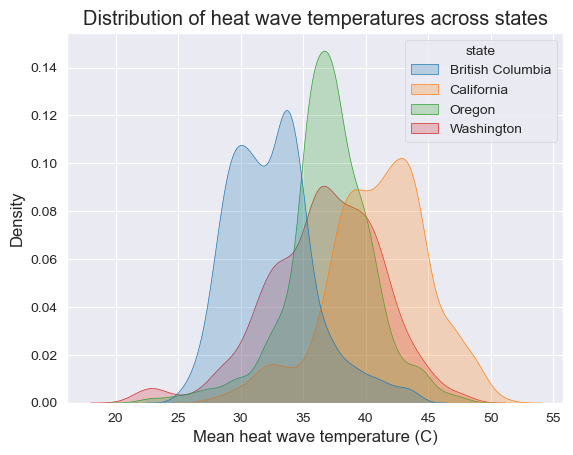

In [540]:
sns.kdeplot(is_heatwave, x='temperature_2m', hue='state', common_norm=False, fill=True)
plt.xlabel("Mean heat wave temperature (C)")
plt.title("Distribution of heat wave temperatures across states")
plt.savefig(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/eadi_img/intensity_distribution.png', dpi=500)


### Get heat wave temperatures relative to their county's mean (proxy for severity)

Thoughts
* On average, heat waves in British Columbia's have the highest deviation from county average maximum summer temperatures

In [506]:
daily_BC = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/daily_BC_counties.csv')
monthly = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps_weekly.csv')
weekly = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps_monthly.csv')
weekly_o = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps_weekly_oregon.csv')

In [507]:
all_df = pd.concat([daily_BC, monthly, weekly, weekly_o])

In [508]:
all_df['location'] = all_df['county'] + ', ' + all_df['state']

In [509]:
all_temps = all_df.groupby('location')['temperature_2m'].mean().reset_index()

In [510]:
all_temps.columns = ['location', 'county_avg_temp']

In [511]:
heatwaves = heatwaves.merge(all_temps, on='location')

In [512]:
heatwaves['diff_from_avg'] = heatwaves['temperature_2m'] - heatwaves['county_avg_temp']

In [513]:
zscore = lambda x: (x / x.std())

In [514]:
heatwaves['zscores'] = heatwaves.groupby('location')['diff_from_avg'].transform(zscore)

In [515]:
is_heatwave = heatwaves[heatwaves['heatwave'] == 1]

In [516]:
is_heatwave.groupby('state')['zscores'].describe()[['mean', 'min', 'max']].style.background_gradient(cmap='Reds')

,mean,min,max
state,,,
British Columbia,1.948619,0.565029,4.186230
California,1.583300,0.666532,3.912211
Oregon,1.543114,-0.425406,3.676764
Washington,1.737374,-0.045863,5.198735


In [517]:
zscores = is_heatwave.groupby('state')['zscores'].mean().reset_index()

In [520]:
zscores

,state,zscores
0,British Columbia,1.948619
1,California,1.583300
2,Oregon,1.543114
3,Washington,1.737374


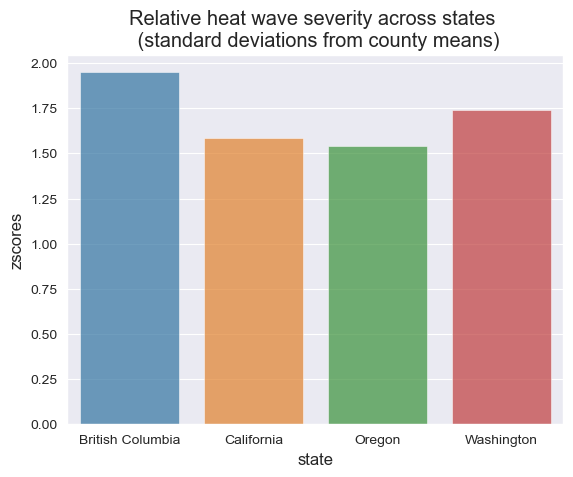

In [521]:
sns.barplot(zscores, x='state', y='zscores', alpha=0.7)
plt.title("Relative heat wave severity across states \n (standard deviations from county means)")
plt.show()

In [523]:
is_heatwave.sort_values(by='state', inplace=True)

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_64061/295634211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_heatwave.sort_values(by='state', inplace=True)


Text(0.5, 1.0, 'Distribution of relative heat wave severity across states \n (standard deviations from county means)')

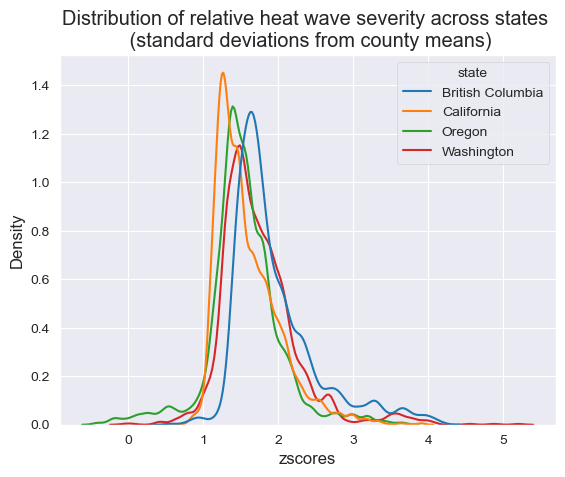

In [524]:
sns.kdeplot(is_heatwave, x='zscores', hue='state', common_norm=False)
plt.title("Distribution of relative heat wave severity across states \n (standard deviations from county means)")

### Explore heat wave frequency summary statistics 

#### Method 1: For each county, calculate have days per summer days, aggregate to the state level

In [4]:
heatwaves = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/complete_heatwaves/heatwaves.csv')

In [5]:
heatwaves_per_summer_days = heatwaves.groupby(['year', 'location'])['heatwave'].apply(lambda x: x.sum() / x.count()).reset_index()

In [6]:
heatwaves_per_summer_days.columns = ['year','location', 'heatwave_freq']

In [7]:
heatwaves = heatwaves.merge(heatwaves_per_summer_days, on='location')

In [8]:
heatwave_freq = heatwaves.drop_duplicates(['location', 'heatwave_freq', 'year_y'])

In [9]:
heatwave_freq.sort_values(by='state', inplace=True)

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_8231/2421035164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatwave_freq.sort_values(by='state', inplace=True)


<AxesSubplot:xlabel='year_y', ylabel='heatwave_freq'>

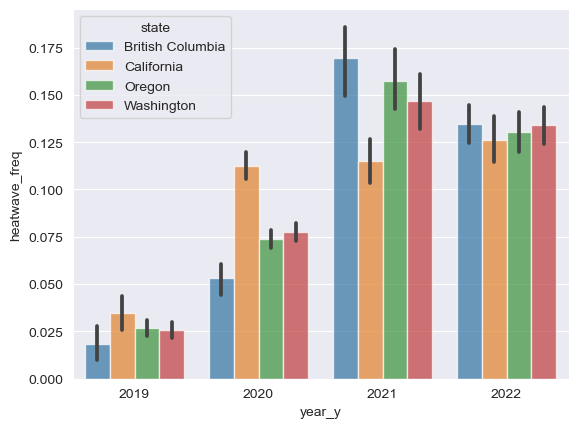

In [10]:
sns.barplot(heatwave_freq, x='year_y', y='heatwave_freq', hue='state', alpha=0.7)

In [11]:
heatwave_freq.groupby(['year_y', 'state'])['heatwave_freq'].describe().style.background_gradient(cmap='Reds')

#### Separate heat wave frequency by year and month

In [12]:
heatwaves = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/heatwave_full.csv')

In [13]:
heatwaves_per_summer_days = heatwaves.groupby(['year', 'month', 'location'])['heatwave'].apply(lambda x: x.sum() / x.count()).reset_index()

In [14]:
heatwaves_per_summer_days.columns = ['year', 'month','location', 'heatwave_freq']

In [15]:
heatwaves = heatwaves.merge(heatwaves_per_summer_days, on='location')

In [16]:
heatwave_freq = heatwaves.drop_duplicates(['location', 'heatwave_freq', 'year_y'])

In [17]:
heatwave_freq.sort_values(by='state', inplace=True)

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_8231/2421035164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatwave_freq.sort_values(by='state', inplace=True)


/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_8231/394038435.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(temp_df, x='year_y', y='heatwave_freq', hue='month_y', alpha=0.7, ax=axes[i], ci=False)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_8231/394038435.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(temp_df, x='year_y', y='heatwave_freq', hue='month_y', alpha=0.7, ax=axes[i], ci=False)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_8231/394038435.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(temp_df, x='year_y', y='heatwave_freq', hue='month_y', alpha=0.7, ax=axes[i], ci=False)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_8231/394038435.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('c

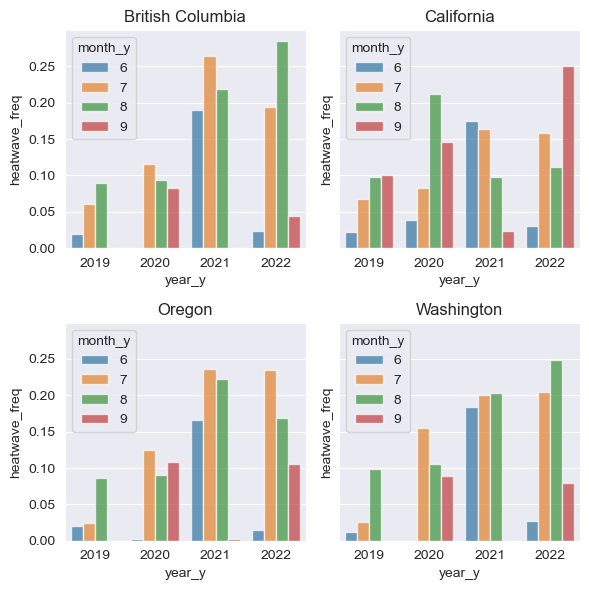

In [18]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(6, 6), sharey=True)
axes = (ax0, ax1, ax2, ax3)
for i in range(len(heatwave_freq.state.unique())):
    temp_df = heatwave_freq[heatwave_freq['state'] == heatwave_freq.state.unique()[i]]
    sns.barplot(temp_df, x='year_y', y='heatwave_freq', hue='month_y', alpha=0.7, ax=axes[i], ci=False)
    axes[i].set_title(f"{heatwave_freq.state.unique()[i]}")          

plt.tight_layout()
plt.savefig(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/eadi_img/monthly_frequencies.png', dpi=500)




#### Get county in each state with the highest annual heat wave frequency

In [601]:
max_freq_counties = heatwave_freq[heatwave_freq.groupby(['state', 'year_y'])['heatwave_freq'].transform(max) == heatwave_freq['heatwave_freq']][['year_y', 'location', 'state', 'heatwave_freq']].sort_values(by=['year_y', 'state'])

In [602]:
for state in max_freq_counties.state.unique():
    display(max_freq_counties[max_freq_counties['state'] == state].style.background_gradient(cmap='Reds'))

,year_y,location,state,heatwave_freq
593409,2019,"Stikine, British Columbia",British Columbia,0.258065
530949,2020,"Fraser Valley, British Columbia",British Columbia,0.193548
546565,2020,"Greater Vancouver, British Columbia",British Columbia,0.193548
523145,2021,"East Kootenay, British Columbia",British Columbia,0.580645
609038,2022,"Northern Rockies, British Columbia",British Columbia,0.483871
585614,2022,"Peace River, British Columbia",British Columbia,0.483871


,year_y,location,state,heatwave_freq
421633,2019,"Imperial, California",California,0.290323
421638,2020,"Imperial, California",California,0.451613
733961,2021,"Modoc, California",California,0.548387
897933,2022,"Lassen, California",California,0.387097
374797,2022,"Alpine, California",California,0.387097


,year_y,location,state,heatwave_freq
85890,2019,"Lincoln, Oregon",Oregon,0.161290
1046274,2019,"Douglas, Oregon",Oregon,0.161290
1249287,2020,"Coos, Oregon",Oregon,0.333333
7817,2021,"Baker, Oregon",Oregon,0.612903
242057,2021,"Malheur, Oregon",Oregon,0.612903
1093133,2022,"Harney, Oregon",Oregon,0.419355


,year_y,location,state,heatwave_freq
1124354,2019,"Okanogan, Washington",Washington,0.161290
1218050,2019,"Lincoln, Washington",Washington,0.161290
359170,2019,"Douglas, Washington",Washington,0.161290
1124357,2020,"Okanogan, Washington",Washington,0.225806
210821,2020,"Ferry, Washington",Washington,0.225806
117125,2020,"Yakima, Washington",Washington,0.225806
406025,2021,"Stevens, Washington",Washington,0.483871
460686,2022,"Columbia, Washington",Washington,0.322581


## Heat Wave Frequency (Unique Heatwaves)

In [52]:
heatwaves = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/heatwave_full.csv')

In [53]:
heatwaves['new_event'] = heatwaves['Heat Wave Duration'].notnull() * 1

In [71]:
heat_freq = heatwaves.groupby(['year', 'state', 'month'])['new_event'].sum().reset_index()

In [72]:
heat_freq

,year,state,month,new_event
0,2019,British Columbia,6,10
1,2019,British Columbia,7,5
2,2019,British Columbia,8,10
3,2019,British Columbia,9,0
4,2019,California,6,14
...,...,...,...,...
59,2022,Oregon,9,29
60,2022,Washington,6,17
61,2022,Washington,7,40
62,2022,Washington,8,108


In [83]:
heat_freq

,year,state,month,new_event
0,2019,British Columbia,6,10
1,2019,British Columbia,7,5
2,2019,British Columbia,8,10
3,2019,British Columbia,9,0
4,2019,California,6,14
...,...,...,...,...
59,2022,Oregon,9,29
60,2022,Washington,6,17
61,2022,Washington,7,40
62,2022,Washington,8,108


In [89]:
heat_freq.dtypes

year          int64
state        object
month         int64
new_event     int64
dtype: object

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_8231/3931057323.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(heat_freq, x='year', y='new_event', hue='state', alpha=0.7,  ci=False)


<AxesSubplot:xlabel='year', ylabel='new_event'>

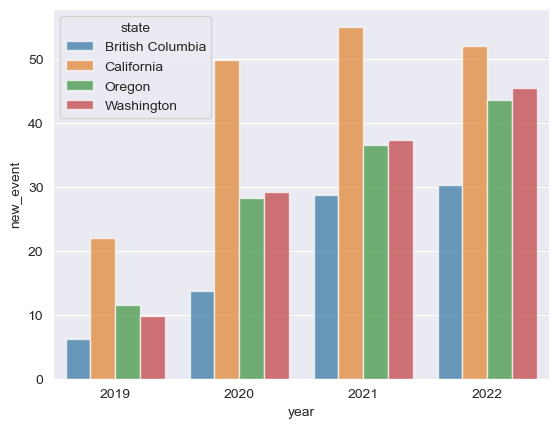

In [93]:
sns.barplot(heat_freq, x='year', y='new_event', hue='state', alpha=0.7,  ci=False)
#plt.show()

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_8231/1440868968.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(temp_df, x='year', y='new_event', hue='month', alpha=0.7, ax=axes[i], ci=False)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_8231/1440868968.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(temp_df, x='year', y='new_event', hue='month', alpha=0.7, ax=axes[i], ci=False)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_8231/1440868968.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(temp_df, x='year', y='new_event', hue='month', alpha=0.7, ax=axes[i], ci=False)
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_8231/1440868968.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the 

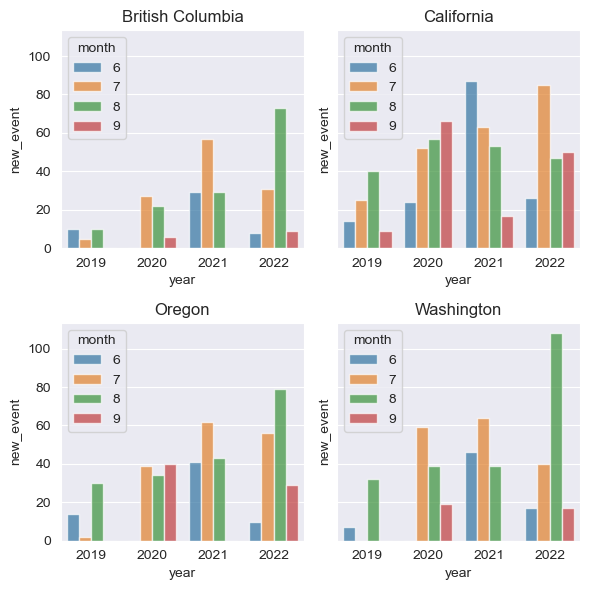

In [81]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(6, 6), sharey=True)
axes = (ax0, ax1, ax2, ax3)
for i in range(len(heat_events.state.unique())):
    temp_df = heat_freq[heat_freq['state'] == heat_freq.state.unique()[i]]
    sns.barplot(temp_df, x='year', y='new_event', hue='month', alpha=0.7, ax=axes[i], ci=False)
    axes[i].set_title(f"{heatwave_freq.state.unique()[i]}")          

plt.tight_layout()
plt.savefig(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/eadi_img/monthly_frequencies.png', dpi=500)





### Explore heat wave duration summary statistics 

In [593]:
is_heatwave.groupby('State')['Heat Wave Duration'].describe()[['mean', '50%', 'min', 'max', 'std']].style.background_gradient(cmap='Reds')

,mean,50%,min,max,std
State,,,,,
British Columbia,4.362712,4.000000,2.000000,12.000000,2.270927
California,3.853315,3.000000,2.000000,19.000000,2.172876
Oregon,3.714286,3.000000,2.000000,19.000000,2.433710
Washington,3.868778,3.000000,2.000000,12.000000,1.967070


<AxesSubplot:xlabel='state', ylabel='Heat Wave Duration'>

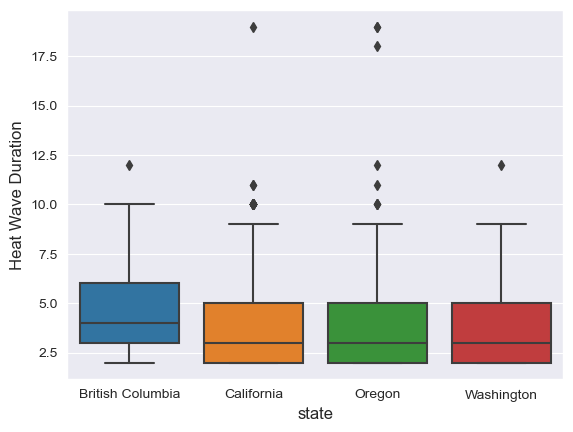

In [550]:
sns.boxplot(is_heatwave, x='state', y='Heat Wave Duration')

In [543]:
temp_means = heatwaves.groupby('state')['Heat Wave Duration'].mean().reset_index()

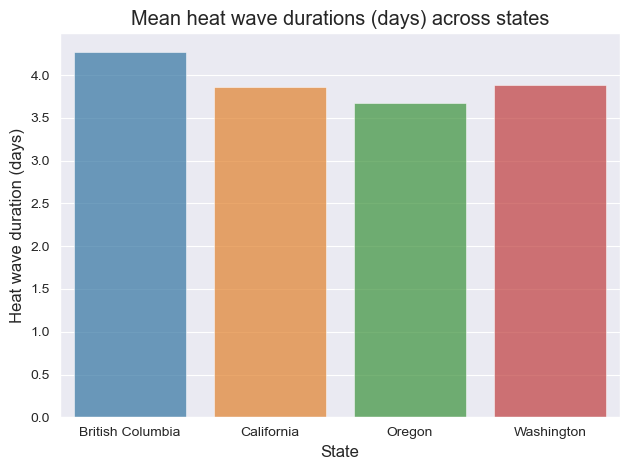

In [545]:
sns.barplot(temp_means, x='state', y='Heat Wave Duration', alpha=0.7)
plt.title("Mean heat wave durations (days) across states")
plt.xlabel("State")
plt.ylabel("Heat wave duration (days)")
plt.tight_layout()
plt.savefig(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/eadi_img/mean_duration.png', dpi=500)


plt.show()

In [554]:
is_heatwave.rename(columns={'state':"State"},inplace=True)

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_64061/1946117197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_heatwave.rename(columns={'state':"State"},inplace=True)


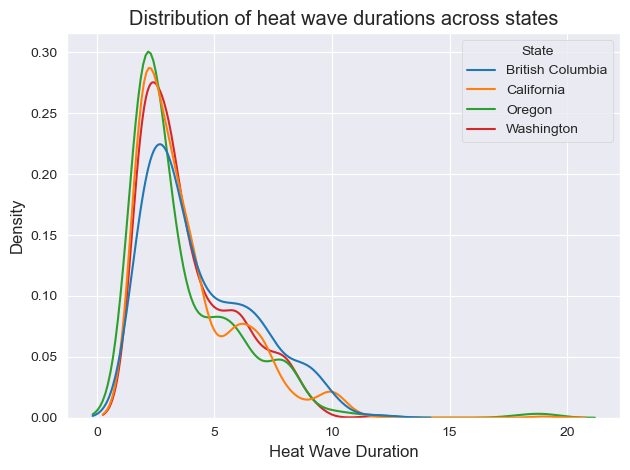

In [556]:
sns.kdeplot(is_heatwave, x='Heat Wave Duration', hue='State', common_norm=False, fill=False)
plt.title("Distribution of heat wave durations across states")
plt.tight_layout()
plt.savefig(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/eadi_img/duration_distribution.png', dpi=500)




In [572]:
mean_heatwave_temps = heatwaves.groupby('heat_ID')['temperature_2m'].mean().reset_index().sort_values(by='temperature_2m', ascending=False)

In [573]:
ID_durations = heatwaves.groupby('heat_ID')['Heat Wave Duration'].mean().reset_index()

In [574]:
heatwave_info = mean_heatwave_temps.merge(ID_durations, on='heat_ID')

In [575]:
heatwave_info = heatwave_info.merge(heatwaves[['heat_ID', 'state']].drop_duplicates())

In [576]:
heatwave_info['temp_percentile'] = heatwave_info['temperature_2m'].rank(pct=True)

In [577]:
heatwave_info['duration_percentile'] = heatwave_info['Heat Wave Duration'].rank(pct=True)

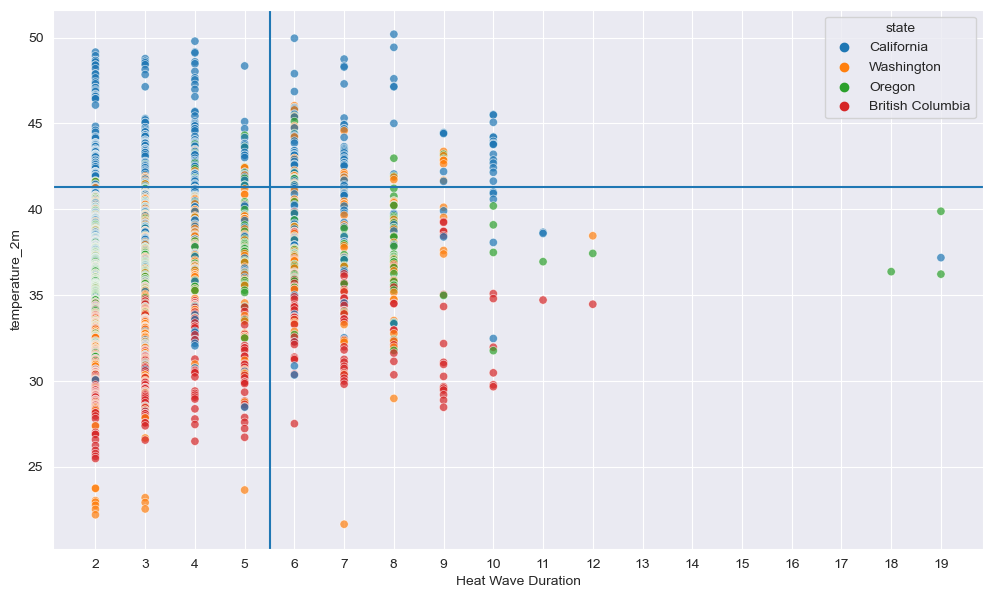

In [578]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(heatwave_info, x='Heat Wave Duration', y='temperature_2m', hue='state',  ax=ax, alpha=0.7)
ax.axhline(np.percentile(heatwave_info['temperature_2m'], q=80))
ax.axvline(np.percentile(heatwave_info['Heat Wave Duration'], q=80) - 0.5)
ax.set_xticks(range(int(min(heatwave_info['Heat Wave Duration'])), int(max(heatwave_info['Heat Wave Duration']+1))))
plt.show()

In [563]:
heatwave_info[(heatwave_info['temp_percentile'] >= 0.8) & (heatwave_info['duration_percentile'] >= 0.8)]['state']

0      California
1      California
3      California
9      California
21     California
          ...    
394    Washington
396        Oregon
397    California
401    California
404    California
Name: state, Length: 135, dtype: object

In [4]:
geom_dic = {}
shapes = []
geom_names = {}
for state in ['Oregon', 'California', 'British Columbia / Colombie-Britannique', 'Washington']:
    
    geom_dic[state] = {}
    geom_names[state] ={}


    filteredArea = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM1_NAME', state));

    county_data = filteredArea.distinct('ADM2_CODE').getInfo()

    for item in county_data['features']:
        
        geom_names[state][item['properties']['ADM2_NAME']] = 1

        if (item['geometry']['type'] == 'MultiPolygon'):
            county_geometry = []
            county_name = item['properties']['ADM2_NAME']
            print(county_name)
            
            for polygon in item['geometry']['coordinates']:
                county_geometry.append(Polygon(polygon[0]))       
            county_multi = MultiPolygon(county_geometry)
            geom_dic[state][county_name] = county_multi


        if (item['geometry']['type'] == 'Polygon'):    
            county_name = item['properties']['ADM2_NAME']
            geom_dic[state][county_name] = Polygon(item['geometry']['coordinates'][0])

        if (item['geometry']['type'] == 'GeometryCollection'): 
            county_geometry = []
            county_name = item['properties']['ADM2_NAME']
            print(len(item['geometry']['geometries']))
            for shape in item['geometry']['geometries']:
                shapes.append(shape['type'])
                if shape['type'] == 'Polygon':
                    county_geometry.append(Polygon(shape['coordinates'][0]))
                if shape['type'] == 'LineString':
                    county_geometry.append(LineString(shape['coordinates']))
            county_multi = GeometryCollection(county_geometry)
            geom_dic[state][county_name] = county_multi
            
            
     #       county_name = item['properties']['ADM2_NAME']
      #      geom_dic[state][county_name] = Polygon(item['geometry']['geometries'][1]['coordinates'][0])

Clatsop
Columbia
Coos
Curry
2
Lincoln
Tillamook
Del Norte
Humboldt
Alameda
Contra Costa
2
Los Angeles
Marin
Mendocino
Monterey
Orange
Sacramento
San Diego
79
San Luis Obispo
30
Santa Barbara
27
Solano
Sonoma
Ventura
Squamish-Lillooet
Sunshine Coast
Comox Valley
Strathcona
Alberni-Clayoquot
Capital
Central Coast
Cowichan Valley
Greater Vancouver
Kitimat-Stikine
Mount Waddington
161
Powell River
8499
Clallam
Cowlitz
Grays Harbor
Island
Jefferson
King
Kitsap
Mason
Pacific
Pierce
San Juan
Skagit
Snohomish
Thurston
Wahkiakum
Whatcom


In [5]:
heatwaves = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/heatwave.csv')

In [6]:
heatwaves = heatwaves[heatwaves['year'] >= 2019]

In [7]:
shapes = pd.DataFrame.from_dict(geom_dic).unstack().reset_index()

In [8]:
shapes.columns = ['state', 'county', 'geometry']

In [9]:
shapes.replace('British Columbia / Colombie-Britannique', 'British Columbia', inplace=True) 

In [10]:
full_hw = heatwaves.merge(shapes, on=['state', 'county'])

In [11]:
full_hw = gpd.GeoDataFrame(full_hw, crs='epsg: 4326')

In [12]:
full_hw['state'].unique()

array(['British Columbia', 'California', 'Oregon', 'Washington'],
      dtype=object)

<AxesSubplot:>

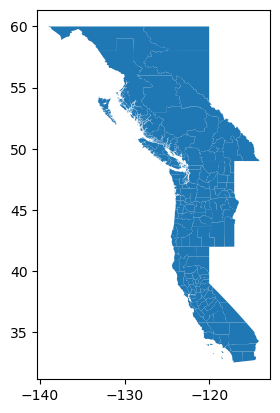

In [12]:
full_hw.drop_duplicates(subset=['state', 'county']).plot()

In [15]:
full_hw.sort_values('datetime', inplace=True)

In [16]:
full_hw['location'] = full_hw['county'] + ', ' + full_hw['state']

In [17]:
full_hw.sort_values(by='datetime', inplace=True)

In [18]:
full_hw = full_hw[full_hw['month'] != 5]
full_hw = full_hw[full_hw['month'] != 10]

In [19]:
full_hw

,Unnamed: 0.1,Unnamed: 0,county,day,month,year,temperature_2m,state,datetime,datetime_ord,level_0,heatwave,geometry,location
3911,15182,7,Bulkley-Nechako,1,6,2019,26.163980,British Columbia,2019-06-01,737211,NaN,0.0,"POLYGON ((-128.48555 55.94484, -128.45517 55.9...","Bulkley-Nechako, British Columbia"
68320,119642,510,Kitsap,1,6,2019,25.355386,Washington,2019-06-01,737211,NaN,0.0,"MULTIPOLYGON (((-122.53613 47.69942, -122.5360...","Kitsap, Washington"
53192,88958,630,Linn,1,6,2019,25.609293,Oregon,2019-06-01,737211,NaN,0.0,"POLYGON ((-123.18398 44.28369, -123.18334 44.2...","Linn, Oregon"
614,1969,1,Northern Rockies,1,6,2019,24.415933,British Columbia,2019-06-01,737211,NaN,0.0,"POLYGON ((-127.81058 59.75934, -127.80630 59.7...","Northern Rockies, British Columbia"
49288,88718,390,Hood River,1,6,2019,26.742914,Oregon,2019-06-01,737211,NaN,0.0,"POLYGON ((-121.69681 45.25802, -121.69133 45.2...","Hood River, Oregon"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,1602,2,Peace River,30,9,2022,20.768564,British Columbia,2022-09-30,738428,NaN,0.0,"POLYGON ((-124.94836 57.99987, -124.93915 57.9...","Peace River, British Columbia"
522,1601,1,Northern Rockies,30,9,2022,20.891245,British Columbia,2022-09-30,738428,NaN,0.0,"POLYGON ((-127.81058 59.75934, -127.80630 59.7...","Northern Rockies, British Columbia"
34,1600,0,Kitimat-Stikine,30,9,2022,18.537729,British Columbia,2022-09-30,738428,NaN,0.0,"MULTIPOLYGON (((-129.66286 53.03561, -129.6627...","Kitimat-Stikine, British Columbia"
33671,75283,1109,San Francisco,30,9,2022,26.182626,California,2022-09-30,738428,NaN,0.0,GEOMETRYCOLLECTION (LINESTRING (-122.48349 37....,"San Francisco, California"
